# Sanity check for simplifying assumptions taken
This is a notebook to check if the simplifying assumptions can be justified or if any counter measures should be taken in order to make the model more realistic

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from edisgo.edisgo import import_edisgo_from_files
from edisgo.flex_opt.optimization import setup_model, optimize, check_mapping
from edisgo.tools.tools import convert_impedances_to_mv, extract_feeders_nx

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning:

Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning:

Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?



## Power flow
Check if linearisation of power flow holds

Pay special attention to:
- Bus voltages and line loading: Are they in a tolerable range within the AC values?
- Power factor: Should this be determined per node?
- Curtailment: Does this make any sense or do we have to adapt the approach?

In [3]:
# check highest overloading and highest voltage deviation for each grid
loading = {}
voltage_dev = {}
grid_ids = [176, 177, 1056, 1690, 1811, 2534]
for grid_id in grid_ids:
    res_dir = r'U:\Software\eDisGo_object_files\simbev_nep_2035_results\{}\dumb'.format(grid_id)
    loading[grid_id] = pd.read_csv(res_dir+'/relative_load.csv', index_col=0)
    voltage_dev[grid_id] = pd.read_csv(res_dir+'/voltage_deviation.csv', index_col=0)

In [4]:
# import edisgo objects and assign feeder ids
feeders = {}
for grid_id in grid_ids:
    edisgo_dir = r'U:\Software\eDisGo_object_files\simbev_nep_2035_results\{}\dumb'.format(grid_id)
    edisgo_obj = import_edisgo_from_files(edisgo_dir, import_timeseries=False)
    feeders[grid_id] = extract_feeders_nx(edisgo_obj)

Line Branch_LVStation_mvgd_176_lvgd_24435_MVStation_mvgd_176 is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilised. Try to remove connected components and isolated bus first to avoid this warning.
Line Line_BranchTee_Branch_LVStation_mvgd_177_lvgd_42016_MVStation_mvgd_177_Busbar_mvgd_177_MV is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilised. Try to remove connected components and isolated bus first to avoid this warning.
Line Branch_Generator_mvgd_1056_solar_ground_mounted_750200_MVStation_mvgd_1056 is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilised. Try to remove connected components and isolated bus first to avoid this warning.
Line Branch_Generator_mvgd_1056_solar_ground_mounted_752492_MVStation_mvgd_1056 is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilise

Line Line_Busbar_mvgd_1811_MV_Bus_Generator_2622611 is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilised. Try to remove connected components and isolated bus first to avoid this warning.
Line Line_Busbar_mvgd_1811_MV_Bus_Generator_2622612 is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilised. Try to remove connected components and isolated bus first to avoid this warning.
Line Line_Busbar_mvgd_1811_MV_Bus_Generator_2622613 is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilised. Try to remove connected components and isolated bus first to avoid this warning.
Line Line_Busbar_mvgd_1811_MV_Bus_Generator_2622614 is forced to be removed even though it creates isolated buses.The resulting topology cannot be fully utilised. Try to remove connected components and isolated bus first to avoid this warning.
Line Line_Busbar_mvgd_18

In [5]:
# get most overloaded components in grids
max_overloaded_comps = {}
max_voltage_dev = {}
for grid_id in grid_ids:
    max_overloaded_comps[grid_id] = loading[grid_id][loading[grid_id] == loading[grid_id].max().max()].dropna(how='all').dropna(how='all', axis=1)
    max_voltage_dev[grid_id] = voltage_dev[grid_id][voltage_dev[grid_id].abs() == voltage_dev[grid_id].abs().max().max()].dropna(how='all').dropna(how='all', axis=1)

In [6]:
# get feeder of max overloaded component and bus with max voltage deviation
setup = pd.DataFrame(columns=['feeder', 'time'])
for grid_id in grid_ids:
    i=0
    print('Grid {}'.format(grid_id))
    for feeder in feeders[grid_id]:
        if max_overloaded_comps[grid_id].columns.isin(feeder.topology.lines_df.index) or max_overloaded_comps[grid_id].columns.isin(feeder.topology.transformers_df.index):
            print('    Feeder {} contains most overloaded component'.format(i))
        if max_voltage_dev[grid_id].columns.isin(feeder.topology.buses_df.index):
            print('    Feeder {} contains bus with highest voltage deviation'.format(i))
            setup.loc[grid_id, 'feeder'] = i
            setup.loc[grid_id, 'time'] = max_voltage_dev[grid_id].index[0]
        i+=1
setup

Grid 176
    Feeder 8 contains bus with highest voltage deviation
Grid 177
    Feeder 0 contains bus with highest voltage deviation
Grid 1056
    Feeder 5 contains bus with highest voltage deviation
Grid 1690
    Feeder 3 contains bus with highest voltage deviation
Grid 1811
    Feeder 11 contains bus with highest voltage deviation
Grid 2534
    Feeder 8 contains most overloaded component
    Feeder 8 contains bus with highest voltage deviation


,feeder,time
176,8,2011-01-08 08:00:00
177,0,2011-12-10 08:00:00
1056,5,2011-04-30 07:30:00
1690,3,2011-12-08 09:15:00
1811,11,2011-10-01 06:45:00
2534,8,2011-12-03 08:00:00


In [7]:
# Todo: For these investigations turn off constraints for lower and upper active power on branches
root_dir = r'U:\Software'
voltage_diff = {}
p_cum_diff = {}
q_cum_diff = {}
for grid_id in grid_ids:
    print('Grid {}'.format(grid_id))
    time = pd.to_datetime(setup.loc[grid_id, 'time'])
    if time.hour>=7:
        timesteps = pd.date_range(start=pd.to_datetime(time.date())+pd.Timedelta('7h'), periods=96, freq='15min')
    else:
        timesteps = pd.date_range(start=pd.to_datetime(time.date())-pd.Timedelta('17h'), periods=96, freq='15min')
    feeder_id = setup.loc[grid_id, 'feeder']
    edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2035_results\{}\feeder\{}'.format(grid_id, feeder_id)
    edisgo_orig = import_edisgo_from_files(edisgo_dir, import_timeseries=True)
    tmp = edisgo_orig.timeseries.charging_points_active_power
    charging_optimised = pd.read_csv(root_dir + 
                                     r'\eDisGo_object_files\simbev_nep_2035_results\{}\optimised\timeseries\charging_points_active_power.csv'.format(
                                         grid_id), index_col=0, parse_dates=True)
    tmp.update(charging_optimised)
    edisgo_orig.timeseries.charging_points_active_power = tmp
    edisgo_orig.analyze(timesteps=timesteps)
    edisgo_obj = convert_impedances_to_mv(edisgo_orig)
    try:
        downstream_nodes_matrix = pd.read_csv(
            'grid_data/feeder_data/downstream_node_matrix_{}_{}.csv'.format(grid_id, feeder_id),
            index_col=0)
    except:
        downstream_nodes_matrix = get_downstream_nodes_matrix_iterative(edisgo_obj.topology)
        #downstream_nodes_matrix.to_csv('grid_data/downstream_node_matrix_{}.csv'.format(grid_id))

    downstream_nodes_matrix = downstream_nodes_matrix.astype(np.uint8)
    downstream_nodes_matrix = downstream_nodes_matrix.loc[
            edisgo_obj.topology.buses_df.index,
            edisgo_obj.topology.buses_df.index]
    objective='residual_load'
    model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                                optimize_storage=False, optimize_ev_charging=False,
                                pu=False, v_min=0, v_max=2)
    x_charge, soc, x_charge_ev, energy_level_cp, curtailment_feedin, \
                   curtailment_load,  curtailment_ev, \
                   v_bus, p_line, q_line, slack_charging, slack_energy, slack_v_pos, slack_v_neg, \
                   slack_p_cum_pos, slack_p_cum_neg = optimize(model, 'gurobi')
    print('    Sum of curtailment load: {}'.format(curtailment_load.sum().sum()))
    print('    Sum of curtailment feedin: {}'.format(curtailment_feedin.sum().sum()))
    print('    Sum of slack v pos: {}'.format(slack_v_pos.sum().sum()))
    print('    Sum of slack v neg: {}'.format(slack_v_neg.sum().sum()))
    print('    Sum of slack p cum pos: {}'.format(slack_p_cum_pos.sum().sum()))
    print('    Sum of slack p cum neg: {}'.format(slack_p_cum_neg.sum().sum()))
    voltage_diff[grid_id] = v_bus/edisgo_obj.topology.mv_grid.nominal_voltage-edisgo_obj.results.v_res
    p_cum_diff[grid_id] = p_line.abs()-edisgo_obj.results.pfa_p.abs()
    q_cum_diff[grid_id] = q_line.abs()-edisgo_obj.results.pfa_q.abs()

Grid 176


c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
               '2011-01-08 08:00:00', '2011-01-08 08:15:00',
               '2011-01-08 08:30:00', '2011-01-08 08:45:00',
               '2011-01-08 09:00:00', '2011-01-08 09:15:00',
               '2011-01-08 09:30:00', '2011-01-08 09:45:00',
               '2011-01-08 10:00:00', '2011-01-08 10:15:00',
               '2011-01-08 10:30:00', '2011-01-08 10:45:00',
               '2011-01-08 11:00:00', '2011-01-08 11:15:00',
    

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068597 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099828 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084191 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084727 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084233 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068599 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084225 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068597 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078223 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084234 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.


c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.
Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpvv5s23mk.pyomo.lp
Reading time = 37.94 seconds
x2854369: 1268737 rows, 2220193 columns, 26567617 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1268737 rows, 2220193 columns and 26567617 nonzeros
Model fingerprint: 0x80c68b35
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [6e-08, 2e-01]
  RHS range        [1e-06, 2e+03]
Presolve removed 13177 rows and 850000 columns (presolve time = 6s) ...
Presolve removed 539591 rows and 1376823 columns (presolve time = 10s) ...
Presolve removed 539591 rows and 1376823 columns
Presolv

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-12-10 07:00:00', '2011-12-10 07:15:00',
               '2011-12-10 07:30:00', '2011-12-10 07:45:00',
               '2011-12-10 08:00:00', '2011-12-10 08:15:00',
               '2011-12-10 08:30:00', '2011-12-10 08:45:00',
               '2011-12-10 09:00:00', '2011-12-10 09:15:00',
               '2011-12-10 09:30:00', '2011-12-10 09:45:00',
               '2011-12-10 10:00:00', '2011-12-10 10:15:00',
               '2011-12-10 10:30:00', '2011-12-10 10:45:00',
               '2011-12-10 11:00:00', '2011-12-10 11:15:00',
               '2011-12-10 11:30:00', '2011-12-10 11:45:00',
               '2011-12-10 12:00:00', '2011-12-10 12:15:00',
               '2011-12-10 12:30:00', '2011-12-10 12:45:00',
               '2011-12-10 13:00:00', '2011-12-10 13:15:00',
               '2011-12-10 13:30:00', '2011-12-10 13:45:00',
               '2011-12-10 14:00:00', '2011-12-10 14:15:0

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037288 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031317 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.021662 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031252 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031250 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053478 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046878 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037355 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031242 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.
Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpmsu8n_5g.pyomo.lp
Reading time = 0.43 seconds
x96481: 43009 rows, 75169 columns, 252165 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 43009 rows, 75169 columns and 252165 nonzeros
Model fingerprint: 0x30fe462a
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [6e-03, 1e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [6e-08, 2e-01]
  RHS range        [1e-07, 4e+02]
Presolve removed 24976 rows and 54205 columns
Presolve time: 0.10

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-04-30 07:00:00', '2011-04-30 07:15:00',
               '2011-04-30 07:30:00', '2011-04-30 07:45:00',
               '2011-04-30 08:00:00', '2011-04-30 08:15:00',
               '2011-04-30 08:30:00', '2011-04-30 08:45:00',
               '2011-04-30 09:00:00', '2011-04-30 09:15:00',
               '2011-04-30 09:30:00', '2011-04-30 09:45:00',
               '2011-04-30 10:00:00', '2011-04-30 10:15:00',
               '2011-04-30 10:30:00', '2011-04-30 10:45:00',
               '2011-04-30 11:00:00', '2011-04-30 11:15:00',
               '2011-04-30 11:30:00', '2011-04-30 11:45:00',
               '2011-04-30 12:00:00', '2011-04-30 12:15:00',
               '2011-04-30 12:30:00', '2011-04-30 12:45:00',
               '2011-04-30 13:00:00', '2011-04-30 13:15:00',
               '2011-04-30 13:30:00', '2011-04-30 13:45:00',
               '2011-04-30 14:00:00', '2011-04-30 14:15:0

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084158 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078198 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.080696 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084233 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084224 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068655 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084226 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084223 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068528 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084161 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.
Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpztmsl4hp.pyomo.lp
Reading time = 34.94 seconds
x3075553: 1367041 rows, 2392225 columns, 28127065 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1367041 rows, 2392225 columns and 28127065 nonzeros
Model fingerprint: 0x36fa6c58
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [9e-07, 9e+01]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [6e-08, 2e-01]
  RHS range        [5e-09, 4e+02]
Presolve removed 10716 rows and 910000 columns (pr

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-12-08 07:00:00', '2011-12-08 07:15:00',
               '2011-12-08 07:30:00', '2011-12-08 07:45:00',
               '2011-12-08 08:00:00', '2011-12-08 08:15:00',
               '2011-12-08 08:30:00', '2011-12-08 08:45:00',
               '2011-12-08 09:00:00', '2011-12-08 09:15:00',
               '2011-12-08 09:30:00', '2011-12-08 09:45:00',
               '2011-12-08 10:00:00', '2011-12-08 10:15:00',
               '2011-12-08 10:30:00', '2011-12-08 10:45:00',
               '2011-12-08 11:00:00', '2011-12-08 11:15:00',
               '2011-12-08 11:30:00', '2011-12-08 11:45:00',
               '2011-12-08 12:00:00', '2011-12-08 12:15:00',
               '2011-12-08 12:30:00', '2011-12-08 12:45:00',
               '2011-12-08 13:00:00', '2011-12-08 13:15:00',
               '2011-12-08 13:30:00', '2011-12-08 13:45:00',
               '2011-12-08 14:00:00', '2011-12-08 14:15:0

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084229 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084284 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084731 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084232 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099864 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099845 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099852 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.122295 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.095502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.080695 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.
Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpw6_5ygqn.pyomo.lp
Reading time = 40.11 seconds
x3672577: 1632385 rows, 2856577 columns, 30114541 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1632385 rows, 2856577 columns and 30114541 nonzeros
Model fingerprint: 0xa537bbd7
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-06, 2e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [6e-08, 4e-01]
  RHS range        [6e-08, 2e+03]
Presolve removed 6480 rows and 1087781 columns (pr

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-09-30 07:00:00', '2011-09-30 07:15:00',
               '2011-09-30 07:30:00', '2011-09-30 07:45:00',
               '2011-09-30 08:00:00', '2011-09-30 08:15:00',
               '2011-09-30 08:30:00', '2011-09-30 08:45:00',
               '2011-09-30 09:00:00', '2011-09-30 09:15:00',
               '2011-09-30 09:30:00', '2011-09-30 09:45:00',
               '2011-09-30 10:00:00', '2011-09-30 10:15:00',
               '2011-09-30 10:30:00', '2011-09-30 10:45:00',
               '2011-09-30 11:00:00', '2011-09-30 11:15:00',
               '2011-09-30 11:30:00', '2011-09-30 11:45:00',
               '2011-09-30 12:00:00', '2011-09-30 12:15:00',
               '2011-09-30 12:30:00', '2011-09-30 12:45:00',
               '2011-09-30 13:00:00', '2011-09-30 13:15:00',
               '2011-09-30 13:30:00', '2011-09-30 13:45:00',
               '2011-09-30 14:00:00', '2011-09-30 14:15:0

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099849 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099862 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099883 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084199 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084229 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084220 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084225 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084239 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099853 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.100308 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.
Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmp5t7i1oup.pyomo.lp
Reading time = 36.83 seconds
x3312289: 1472257 rows, 2576353 columns, 28115953 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1472257 rows, 2576353 columns and 28115953 nonzeros
Model fingerprint: 0x58b3208a
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-06, 3e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [6e-08, 1e+00]
  RHS range        [8e-09, 2e+03]
Presolve removed 6565 rows and 982981 columns (pre

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-12-03 07:00:00', '2011-12-03 07:15:00',
               '2011-12-03 07:30:00', '2011-12-03 07:45:00',
               '2011-12-03 08:00:00', '2011-12-03 08:15:00',
               '2011-12-03 08:30:00', '2011-12-03 08:45:00',
               '2011-12-03 09:00:00', '2011-12-03 09:15:00',
               '2011-12-03 09:30:00', '2011-12-03 09:45:00',
               '2011-12-03 10:00:00', '2011-12-03 10:15:00',
               '2011-12-03 10:30:00', '2011-12-03 10:45:00',
               '2011-12-03 11:00:00', '2011-12-03 11:15:00',
               '2011-12-03 11:30:00', '2011-12-03 11:45:00',
               '2011-12-03 12:00:00', '2011-12-03 12:15:00',
               '2011-12-03 12:30:00', '2011-12-03 12:45:00',
               '2011-12-03 13:00:00', '2011-12-03 13:15:00',
               '2011-12-03 13:30:00', '2011-12-03 13:45:00',
               '2011-12-03 14:00:00', '2011-12-03 14:15:0

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046879 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052977 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046877 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052978 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046875 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049446 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052910 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046941 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037286 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.
Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpmi0p3wzb.pyomo.lp
Reading time = 14.00 seconds
x1144513: 508801 rows, 890305 columns, 11349633 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 508801 rows, 890305 columns and 11349633 nonzeros
Model fingerprint: 0x3ae3ceb9
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-04, 9e+01]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [6e-08, 2e-01]
  RHS range        [5e-09, 4e+02]
Presolve removed 218754 rows and 554766 columns
Presol

In [11]:
def convert_to_single_column_df(tmp):
    col_names = []
    for col in tmp.columns:
        if col != 'grid_id':
            col_names.append(col)
    tmp['grid_id'] = grid_id
    tmp_grid = tmp.melt(id_vars=['grid_id'], value_vars=col_names)#list(var_names.values))
    return tmp_grid

<AxesSubplot:xlabel='grid_id', ylabel='value'>

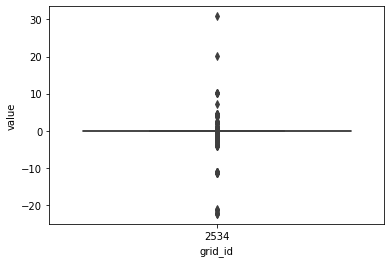

In [18]:
relative_diff_square = p_cum_diff[grid_id].divide(p_line.apply(np.square))

tmp = convert_to_single_column_df(relative_diff_square)
sns.boxplot(data=tmp, x='grid_id', y='value')

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1129: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1129: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1183: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1211: RuntimeWarning:

invalid value encountered in less_equal

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1218: RuntimeWarning:

invalid value encountered in greater_equal

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1183: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\

<AxesSubplot:xlabel='variable', ylabel='value'>

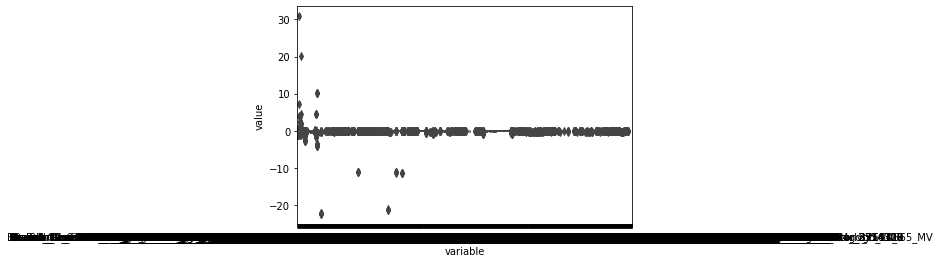

In [19]:
sns.boxplot(data=tmp, x='variable', y='value')

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1129: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1129: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1183: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1211: RuntimeWarning:

invalid value encountered in less_equal

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1218: RuntimeWarning:

invalid value encountered in greater_equal

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\__init__.py:1183: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\matplotlib\cbook\

<AxesSubplot:xlabel='variable', ylabel='value'>

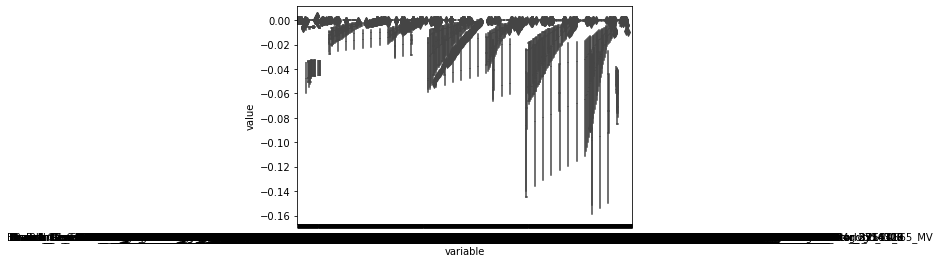

In [15]:
relative_diff = p_cum_diff[grid_id].divide(p_line.abs())
tmp = convert_to_single_column_df(relative_diff)
sns.boxplot(data=tmp, x='grid_id', y='value')

In [ ]:
sns.boxplot(data=tmp, x='variable', y='value')

In [183]:
voltage_diff[grid_id].max().max()

0.02590613392990837

In [110]:
voltage_diff[grid_id].min().min()

0.0

In [115]:
len(voltage_diff[grid_id].columns), len(voltage_diff[grid_id].index)

(1325, 96)

In [113]:
(voltage_diff[grid_id]>0.01).any().sum()

709

In [116]:
(voltage_diff[grid_id]>0.01).any(axis=1).sum()

43

In [122]:
(voltage_diff[grid_id]>0.01).sum().sum()/voltage_diff[grid_id].size

0.0760377358490566

In [109]:
p_cum_diff[grid_id].max().max()

2.7237796698637018e-05

In [131]:
max_dev_p = p_cum_diff[grid_id][p_cum_diff[grid_id]==p_cum_diff[grid_id].min().min()].dropna(how='all').dropna(how='all', axis=1)

In [170]:
max_dev_p

,Branch_LVStation_mvgd_2534_lvgd_20569_MVStation_mvgd_2534
2011-12-03 08:15:00,-0.496883


In [134]:
p_line.loc[max_dev_p.index, max_dev_p.columns], edisgo_obj.results.pfa_p.loc[max_dev_p.index, max_dev_p.columns]

(                     Branch_LVStation_mvgd_2534_lvgd_20569_MVStation_mvgd_2534
 2011-12-03 08:15:00                                          -4.584587        ,
                      Branch_LVStation_mvgd_2534_lvgd_20569_MVStation_mvgd_2534
 2011-12-03 08:15:00                                            5.08147        )

In [157]:
list(loads.values[0])

['Loads_Bus_mvgd_2534_lvgd_20561_loa_1',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_10',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_11',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_12',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_2',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_3',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_4',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_5',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_6',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_7',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_8',
 'Loads_Bus_mvgd_2534_lvgd_20561_loa_9',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_1',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_10',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_11',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_12',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_13',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_2',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_3',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_4',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_5',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_6',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_7',
 'Loads_Bus_mvgd_2534_lvgd_20562_loa_8',
 'Loads_B

In [158]:
model.underlying_branch_elements

,buses,generators,loads,flexible_storage,flexible_ev,pf
Branch_Generator_mvgd_2534_solar_roof_mounted_1601071_MVCableDist_mvgd_2534_8,[Bus_mvgd_2534_gen_1601071],[Generator_mvgd_2534_solar_roof_mounted_1601071],[],[],[],NaN
Branch_Generator_mvgd_2534_solar_roof_mounted_507504_MVCableDist_mvgd_2534_10,[Bus_mvgd_2534_gen_507504],[Generator_mvgd_2534_solar_roof_mounted_507504],[],[],[],NaN
Branch_LVStation_mvgd_2534_lvgd_20561_LVStation_mvgd_2534_lvgd_20562,"[Bus_mvgd_2534_lvgd_20562_loa_7, BranchTee_mvg...","[Generator_solar_LVGrid_20562_2556082, Generat...","[Loads_Bus_mvgd_2534_lvgd_20562_loa_1, Loads_B...",[],[],NaN
Branch_LVStation_mvgd_2534_lvgd_20561_MVCableDist_mvgd_2534_8,"[Bus_mvgd_2534_lvgd_20561_loa_11, BranchTee_mv...",[Generator_mvgd_2534_lvgd_20561_solar_roof_mou...,"[Loads_Bus_mvgd_2534_lvgd_20561_loa_1, Loads_B...",[],[],NaN
Branch_LVStation_mvgd_2534_lvgd_20562_LVStation_mvgd_2534_lvgd_20563,[virtual_BusBar_mvgd_2534_lvgd_20563_MV],[],[],[],[],NaN
Branch_LVStation_mvgd_2534_lvgd_20565_LVStation_mvgd_2534_lvgd_20568,"[BranchTee_mvgd_2534_lvgd_20565_150, BranchTee...",[Generator_mvgd_2534_solar_roof_mounted_160107...,"[Loads_Bus_mvgd_2534_lvgd_20561_loa_1, Loads_B...",[],[],NaN
Branch_LVStation_mvgd_2534_lvgd_20568_MVCableDist_mvgd_2534_10,"[BranchTee_mvgd_2534_lvgd_20565_150, BranchTee...",[Generator_mvgd_2534_solar_roof_mounted_160107...,"[Loads_Bus_mvgd_2534_lvgd_20561_loa_1, Loads_B...",[],[],NaN
Branch_LVStation_mvgd_2534_lvgd_20569_MVCableDist_mvgd_2534_10,"[BranchTee_mvgd_2534_lvgd_20565_150, BranchTee...",[Generator_mvgd_2534_solar_roof_mounted_507504...,"[Loads_Bus_mvgd_2534_lvgd_20561_loa_1, Loads_B...",[],[],NaN
Branch_LVStation_mvgd_2534_lvgd_20569_MVStation_mvgd_2534,"[BranchTee_mvgd_2534_lvgd_20569_149, Bus_mvgd_...",[Generator_mvgd_2534_solar_roof_mounted_507504...,"[Loads_Bus_mvgd_2534_lvgd_20561_loa_1, Loads_B...",[],[],NaN
Branch_Generator_mvgd_2534_lvgd_20561_solar_roof_mounted_1577606_LVCableDist_mvgd_2534_lvgd_20561_18,[Bus_mvgd_2534_lvgd_20561_gen_1577606],[Generator_mvgd_2534_lvgd_20561_solar_roof_mou...,[],[],[],NaN


In [168]:
buses = list(model.underlying_branch_elements.loc[max_dev_p.columns, 'buses'].values[0])
model.nodal_active_power.loc[buses, max_dev_p.index].sum()

2011-12-03 08:15:00   -4.584587
dtype: float64

In [167]:
loads = model.underlying_branch_elements.loc[max_dev_p.columns, 'loads']
cps = model.grid.charging_points_df.loc[model.grid.charging_points_df.bus.isin(
            buses)].index.values
gens = model.underlying_branch_elements.loc[max_dev_p.columns, 'generators']
edisgo_obj.timeseries.generators_active_power.loc[max_dev_p.index, list(gens.values[0])].sum(axis=1)-edisgo_obj.timeseries.loads_active_power.loc[max_dev_p.index, list(loads.values[0])].sum(axis=1)-edisgo_obj.timeseries.charging_points_active_power.loc[max_dev_p.index, cps].sum(axis=1)

2011-12-03 08:15:00   -4.585938
dtype: float16

In [169]:
p_cum_diff[grid_id].dropna(how='all', axis=1).sum(axis=1)

2011-12-03 07:00:00   -3.374177
2011-12-03 07:15:00   -4.196549
2011-12-03 07:30:00   -4.176638
2011-12-03 07:45:00   -4.502762
2011-12-03 08:00:00   -5.635482
2011-12-03 08:15:00   -6.227972
2011-12-03 08:30:00   -5.103961
2011-12-03 08:45:00   -4.354486
2011-12-03 09:00:00   -4.161267
2011-12-03 09:15:00   -3.374350
2011-12-03 09:30:00   -3.206750
2011-12-03 09:45:00   -3.212200
2011-12-03 10:00:00   -3.285690
2011-12-03 10:15:00   -2.764407
2011-12-03 10:30:00   -2.690733
2011-12-03 10:45:00   -2.676269
2011-12-03 11:00:00   -2.660709
2011-12-03 11:15:00   -2.510631
2011-12-03 11:30:00   -2.549047
2011-12-03 11:45:00   -2.766718
2011-12-03 12:00:00   -2.652775
2011-12-03 12:15:00   -2.576608
2011-12-03 12:30:00   -2.454350
2011-12-03 12:45:00   -2.535629
2011-12-03 13:00:00   -2.303512
2011-12-03 13:15:00   -2.261406
2011-12-03 13:30:00   -2.429625
2011-12-03 13:45:00   -2.081562
2011-12-03 14:00:00   -2.282258
2011-12-03 14:15:00   -2.296100
                         ...   
2011-12-

In [135]:
edisgo_obj.results.grid_losses

,p,q
2011-12-03 07:00:00,0.319845,0.314674
2011-12-03 07:15:00,0.369119,0.356734
2011-12-03 07:30:00,0.360579,0.343426
2011-12-03 07:45:00,0.402423,0.399139
2011-12-03 08:00:00,0.469414,0.463888
2011-12-03 08:15:00,0.495835,0.480509
2011-12-03 08:30:00,0.425618,0.420600
2011-12-03 08:45:00,0.387337,0.385353
2011-12-03 09:00:00,0.364854,0.358653
2011-12-03 09:15:00,0.314782,0.311025


In [229]:
v_diff_grids = pd.DataFrame()
for grid_id in grid_ids:
    tmp=voltage_diff[grid_id]
    col_names = []
    for col in tmp.columns:
        col_names.append(col)
    col_names.remove('grid_id')
    tmp['grid_id'] = grid_id
    tmp_grid = tmp.melt(id_vars=['grid_id'], value_vars=col_names)#list(var_names.values))
    v_diff_grids = v_diff_grids.append(tmp_grid)
v_diff_grids.grid_id.unique()

array([ 176,  177, 1056, 1690, 1811, 2534], dtype=int64)

<AxesSubplot:xlabel='grid_id', ylabel='value'>

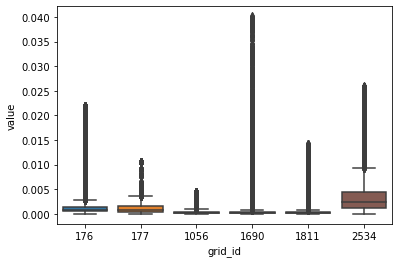

In [230]:
sns.boxplot(data=v_diff_grids, x='grid_id', y='value')

(0.0, 0.01)

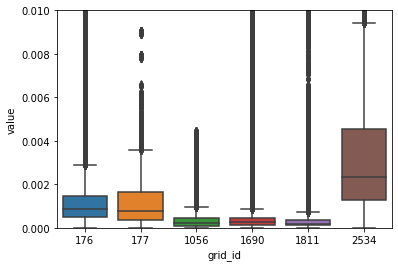

In [234]:
sns.boxplot(data=v_diff_grids, x='grid_id', y='value')
plt.ylim([0, 0.01])

In [237]:
p_cum_grids = pd.DataFrame()
for grid_id in grid_ids:
    tmp=p_cum_diff[grid_id]
    col_names = []
    for col in tmp.columns:
        col_names.append(col)
    #col_names.remove('grid_id')
    tmp['grid_id'] = grid_id
    tmp_grid = tmp.melt(id_vars=['grid_id'], value_vars=col_names)#list(var_names.values))
    p_cum_grids = p_cum_grids.append(tmp_grid)
p_cum_grids.grid_id.unique()

array([ 176,  177, 1056, 1690, 1811, 2534], dtype=int64)

<AxesSubplot:xlabel='grid_id', ylabel='value'>

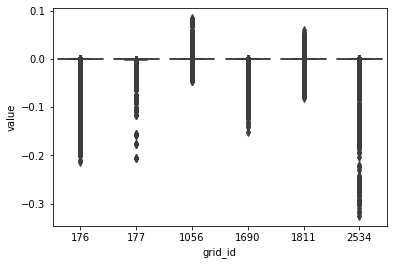

In [238]:
sns.boxplot(data=p_cum_grids, x='grid_id', y='value')

(-0.01, 0.01)

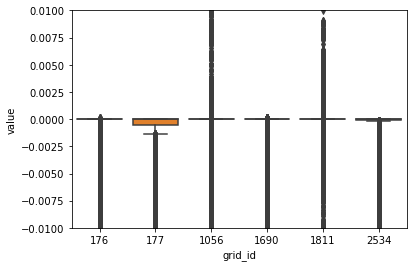

In [239]:
sns.boxplot(data=p_cum_grids, x='grid_id', y='value')
plt.ylim([-0.01, 0.01])

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2056: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2056: FutureWarning:

The `axi

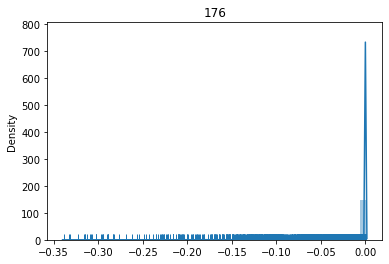

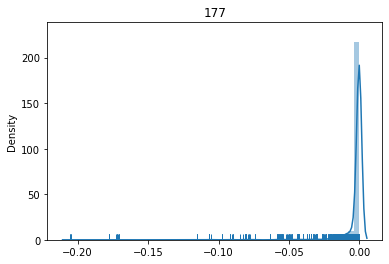

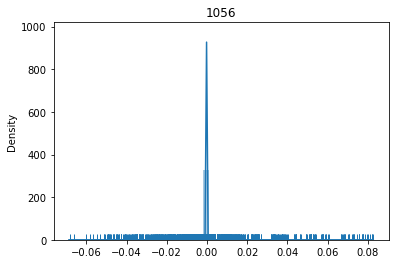

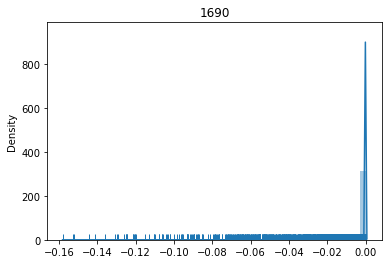

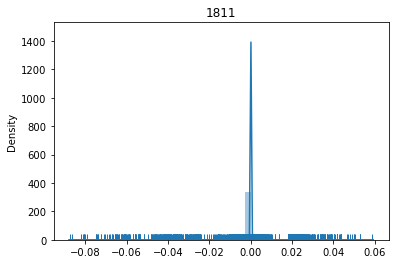

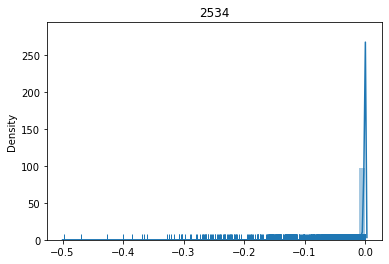

In [129]:
for grid_id in grid_ids:
    plt.figure()
    sns.distplot(p_cum_diff[grid_id], rug=True)
    plt.title(str(grid_id))

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2056: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2056: FutureWarning:

The `axi

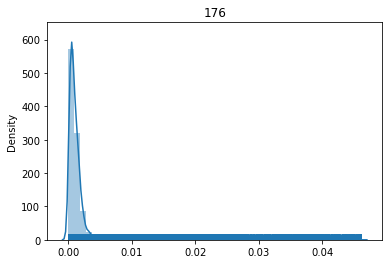

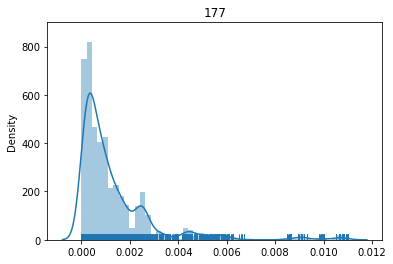

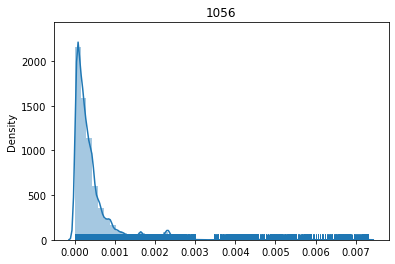

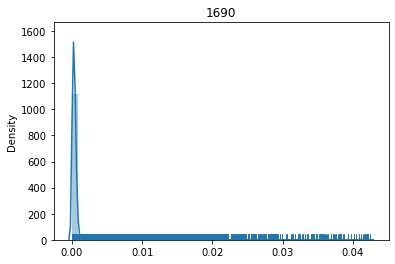

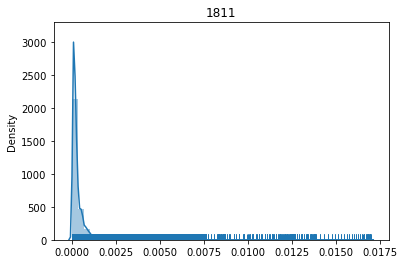

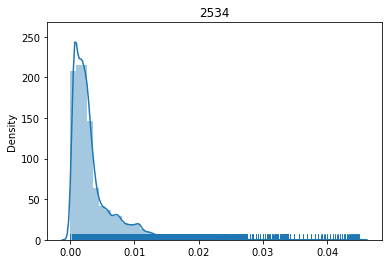

In [130]:
for grid_id in grid_ids:
    plt.figure()
    sns.distplot(voltage_diff[grid_id], rug=True)
    plt.title(str(grid_id))

In [7]:
setup = pd.DataFrame({176: {'feeder': 8, 'time': '2011-01-08 08:00:00'}}).T
#feeder 	time
#176 	8 	2011-01-08 08:00:00
#177 	0 	2011-12-10 08:00:00
#1056 	5 	2011-04-30 07:30:00
#1690 	3 	2011-12-08 09:15:00
#1811 	11 	2011-10-01 06:45:00
#2534 	8 	2011-12-03 08:00:00
setup

,feeder,time
176,8,2011-01-08 08:00:00


In [20]:
# Todo: For these investigations turn off constraints for lower and upper active power on branches
# check if curtailment equals nodal power flows
root_dir = r'U:\Software'
curtailment_load_dict = {}
curtailment_ev_dict = {}
curtailment_feedin_dict = {}
for grid_id in [176]:#grid_ids
    print('Grid {}'.format(grid_id))
    time = pd.to_datetime(setup.loc[grid_id, 'time'])
    if time.hour>=7:
        timesteps = pd.date_range(start=pd.to_datetime(time.date())+pd.Timedelta('7h'), periods=96, freq='15min')
    else:
        timesteps = pd.date_range(start=pd.to_datetime(time.date())-pd.Timedelta('17h'), periods=96, freq='15min')
    feeder_id = setup.loc[grid_id, 'feeder']
    edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2035_results\{}\feeder\{}'.format(grid_id, feeder_id)
    edisgo_orig = import_edisgo_from_files(edisgo_dir, import_timeseries=True)
    edisgo_obj = convert_impedances_to_mv(edisgo_orig)
    try:
        downstream_nodes_matrix = pd.read_csv(
            'grid_data/feeder_data/downstream_node_matrix_{}_{}.csv'.format(grid_id, feeder_id),
            index_col=0)
    except:
        downstream_nodes_matrix = get_downstream_nodes_matrix_iterative(edisgo_obj.topology)
        #downstream_nodes_matrix.to_csv('grid_data/downstream_node_matrix_{}.csv'.format(grid_id))

    downstream_nodes_matrix = downstream_nodes_matrix.astype(np.uint8)
    downstream_nodes_matrix = downstream_nodes_matrix.loc[
            edisgo_obj.topology.buses_df.index,
            edisgo_obj.topology.buses_df.index]
    objective='residual_load'
    model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                                optimize_storage=False, optimize_ev_charging=False,
                                pu=False, v_min=1.0, v_max=1.0)
    x_charge, soc, x_charge_ev, energy_level_cp, curtailment_feedin, \
                   curtailment_load,  curtailment_ev, \
                   v_bus, p_line, q_line, slack_charging, slack_energy, slack_v_pos, slack_v_neg, \
                   slack_p_cum_pos, slack_p_cum_neg = optimize(model, 'gurobi')
    print('    Sum of curtailment load: {}'.format(curtailment_load.sum().sum()))
    print('    Sum of curtailment feedin: {}'.format(curtailment_feedin.sum().sum()))
    print('    Sum of slack v pos: {}'.format(slack_v_pos.sum().sum()))
    print('    Sum of slack v neg: {}'.format(slack_v_neg.sum().sum()))
    print('    Sum of slack p cum pos: {}'.format(slack_p_cum_pos.sum().sum()))
    print('    Sum of slack p cum neg: {}'.format(slack_p_cum_neg.sum().sum()))
    curtailment_load_dict[grid_id] = curtailment_load
    curtailment_ev_dict[grid_id] = curtailment_ev
    curtailment_feedin_dict[grid_id] = curtailment_feedin

Grid 176
More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.


c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.
Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpn31vaexb.pyomo.lp
Reading time = 3.40 seconds
x297331: 132161 rows, 231271 columns, 2757029 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 132161 rows, 231271 columns and 2757029 nonzeros
Model fingerprint: 0xc7eb5d07
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [1e-05, 2e-01]
  RHS range        [1e-06, 4e+02]
Presolve removed 56023 rows and 143487 columns
Presolve time: 0.84s
Presolved: 76138 rows, 87784 columns, 566615 nonzeros
Ordering time: 0.05s

Barrier statistics:
 Free vars  : 10058
 AA' NZ     : 2.020e+06
 Fa

In [23]:
(model.nodal_active_load.T-curtailment_load).dropna(how='all')

name,BusBar_mvgd_176_lvgd_24397_MV,BusBar_mvgd_176_lvgd_24394_MV,BusBar_mvgd_176_lvgd_24395_MV,BusBar_mvgd_176_lvgd_24396_MV,BusBar_mvgd_176_lvgd_24406_MV,BusBar_mvgd_176_lvgd_24402_MV,BusBar_mvgd_176_lvgd_24408_MV,BusBar_mvgd_176_lvgd_24409_MV,BusBar_mvgd_176_lvgd_24418_MV,BusBar_mvgd_176_lvgd_24419_MV,...,Bus_ChargingPoint_2535,Bus_ChargingPoint_2537,Bus_ChargingPoint_2538,Bus_ChargingPoint_2539,Bus_ChargingPoint_2540,Bus_ChargingPoint_2541,Bus_ChargingPoint_2542,Bus_ChargingPoint_2862,Bus_ChargingPoint_3028,Busbar_mvgd_176_MV
2011-01-08 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.168404e-19,0.0,0.0,0.0,0.0,0.0,0.0,4.336809e-19,0.0,0.0
2011-01-08 07:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 07:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 08:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 08:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 08:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2011-01-08 09:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0


In [14]:
curtailment_load

,BusBar_mvgd_176_lvgd_24397_MV,BusBar_mvgd_176_lvgd_24394_MV,BusBar_mvgd_176_lvgd_24395_MV,BusBar_mvgd_176_lvgd_24396_MV,BusBar_mvgd_176_lvgd_24406_MV,BusBar_mvgd_176_lvgd_24402_MV,BusBar_mvgd_176_lvgd_24408_MV,BusBar_mvgd_176_lvgd_24409_MV,BusBar_mvgd_176_lvgd_24418_MV,BusBar_mvgd_176_lvgd_24419_MV,...,Bus_ChargingPoint_2535,Bus_ChargingPoint_2537,Bus_ChargingPoint_2538,Bus_ChargingPoint_2539,Bus_ChargingPoint_2540,Bus_ChargingPoint_2541,Bus_ChargingPoint_2542,Bus_ChargingPoint_2862,Bus_ChargingPoint_3028,Busbar_mvgd_176_MV
2011-01-08 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000636,0.018707,0.015717,0.009369,0.005814,0.010239,0.010536,0.003334,0.0,0.0
2011-01-08 07:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.018707,0.015717,0.012306,0.005814,0.010239,0.010536,0.005535,0.0,0.0
2011-01-08 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.020218,0.015717,0.012306,0.015442,0.010239,0.010536,0.005535,0.0,0.0
2011-01-08 07:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.007019,0.016815,0.012306,0.015442,0.010239,0.010536,0.005535,0.0,0.0
2011-01-08 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.007019,0.021225,0.014503,0.022034,0.010239,0.010536,0.005535,0.0,0.0
2011-01-08 08:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.010803,0.021225,0.014503,0.022034,0.010239,0.006870,0.005535,0.0,0.0
2011-01-08 08:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.010803,0.021225,0.014503,0.022034,0.010239,0.006870,0.005535,0.0,0.0
2011-01-08 08:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.010803,0.021225,0.014503,0.022034,0.010239,0.006870,0.005535,0.0,0.0
2011-01-08 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.008606,0.021225,0.014503,0.022034,0.010239,0.006870,0.005535,0.0,0.0
2011-01-08 09:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002539,0.008606,0.021225,0.014503,0.022034,0.010239,0.006870,0.005535,0.0,0.0


In [74]:

time = pd.to_datetime(setup.loc[grid_id, 'time'])
pd.date_range(start=pd.to_datetime(time.date())-pd.Timedelta('17h'), periods=96, freq='15min')

DatetimeIndex(['2011-12-02 07:00:00', '2011-12-02 07:15:00',
               '2011-12-02 07:30:00', '2011-12-02 07:45:00',
               '2011-12-02 08:00:00', '2011-12-02 08:15:00',
               '2011-12-02 08:30:00', '2011-12-02 08:45:00',
               '2011-12-02 09:00:00', '2011-12-02 09:15:00',
               '2011-12-02 09:30:00', '2011-12-02 09:45:00',
               '2011-12-02 10:00:00', '2011-12-02 10:15:00',
               '2011-12-02 10:30:00', '2011-12-02 10:45:00',
               '2011-12-02 11:00:00', '2011-12-02 11:15:00',
               '2011-12-02 11:30:00', '2011-12-02 11:45:00',
               '2011-12-02 12:00:00', '2011-12-02 12:15:00',
               '2011-12-02 12:30:00', '2011-12-02 12:45:00',
               '2011-12-02 13:00:00', '2011-12-02 13:15:00',
               '2011-12-02 13:30:00', '2011-12-02 13:45:00',
               '2011-12-02 14:00:00', '2011-12-02 14:15:00',
               '2011-12-02 14:30:00', '2011-12-02 14:45:00',
               '2011-12-

In [3]:
# run AC power flow calculation for comparison
edisgo_obj = import_edisgo_from_files(edisgo_dir, import_timeseries=True)
edisgo_obj.analyze(mode='mvlv')

C:\Users\Anya.Heider\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\Anya.Heider\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-08 00:00:00', '2011-01-08 00:15:00',
               '2011-01-08 00:30:00', '2011-01-08 00:45:00',
               '2011-01

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.059933 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.058430 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031249 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046792 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.045400 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046901 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053391 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046902 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048191 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031279 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046832 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053439 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048237 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051877 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.058419 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.058899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051942 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046864 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066240 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.100257 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084612 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067901 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.085506 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078028 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053341 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066170 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.087129 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084615 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.040311 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.059924 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053439 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046903 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037813 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046862 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049073 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.057584 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.045754 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.043638 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056439 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046869 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053246 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.044341 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.055937 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037779 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050845 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041754 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.043291 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046887 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046908 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053440 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046896 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053339 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046903 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031249 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047754 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031280 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037792 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048219 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031278 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046885 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037792 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053737 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053667 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049923 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046891 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053401 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049145 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050801 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053433 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046861 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037550 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047260 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.036323 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046901 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037784 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037782 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037790 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046791 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046865 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046903 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046861 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046884 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034476 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049925 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.057580 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050042 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048213 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048033 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.096846 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037751 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062520 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037583 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.062482 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053016 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069003 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062484 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053391 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053367 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052065 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066436 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.065997 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062491 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.058881 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.052651 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.047403 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.048255 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.051876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.046864 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053379 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031246 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046863 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056206 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.033268 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037747 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052634 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047377 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053370 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046864 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.032600 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.036253 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046870 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037750 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037600 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.045126 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.061467 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [53]:
# import results of optimisation and compare
v_opt = pd.read_csv(results_dir+'bus_voltage_0.csv', index_col=0, parse_dates=True)/edisgo_obj.topology.mv_grid.nominal_voltage
line_active = pd.read_csv(results_dir+'line_active_power_0.csv', index_col=0, parse_dates=True)
line_reactive = pd.read_csv(results_dir+'line_reactive_power_0.csv', index_col=0, parse_dates=True)

In [54]:
v_ref = edisgo_obj.results.v_res
line_active_ref = edisgo_obj.results.pfa_p
line_reactive_ref = edisgo_obj.results.pfa_q

(0.33371195448790303, -0.06417072317331796, 0.03986780237644671)

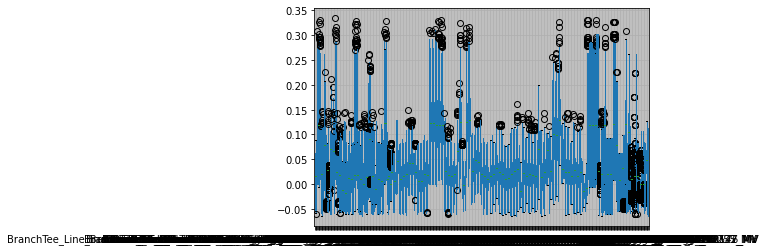

In [55]:
# maximum difference voltage
diff_v_percent = (v_opt-v_ref)*100
diff_v_percent.boxplot()
diff_v_percent.max().max(), diff_v_percent.min().min(), diff_v_percent.mean().mean()

In [60]:
# maximum difference active_power
diff_active = line_active.abs()-line_active_ref.abs()
diff_active.dropna(how='all', inplace=True)
diff_active.dropna(how='all', axis=1, inplace=True)
diff_active.max().max(), diff_active.min().min(), diff_active.mean().mean()

(0.05902744903126189, -0.12523249387973934, -0.002242377795186283)

In [61]:
diff_active.min().idxmin()
time_stamp = pd.to_datetime('2011-01-14 09:15:00')
branch = 'Branch_LVStation_mvgd_1056_lvgd_97723_MVStation_mvgd_1056'
diff_active.loc[time_stamp, branch], line_active.loc[time_stamp, branch], line_active_ref.loc[time_stamp, branch]

(-0.07319473750578354, -3.404, 3.4771947375057835)

In [62]:
# maximum difference active_power
diff_reactive = line_reactive.abs()-line_reactive_ref.abs()
diff_reactive.dropna(how='all', inplace=True)
diff_reactive.dropna(how='all', axis=1, inplace=True)
diff_reactive.max().max(), diff_reactive.min().min(), diff_reactive.mean().mean()

(0.0003968487136348786, -0.320309508040268, -0.008432970251000657)

<AxesSubplot:>

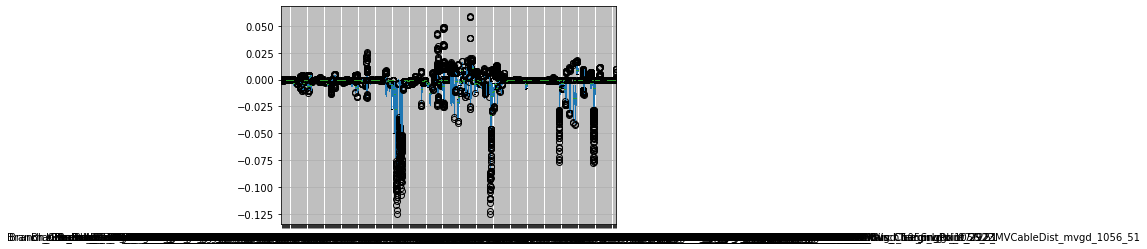

In [63]:
diff_active.boxplot()

In [65]:
# check curtailment
active_curtailment_feedin = pd.read_csv(results_dir+'curtailment_feedin_0.csv', index_col=0, parse_dates=True)
active_curtailment_load = pd.read_csv(results_dir+'curtailment_load_0.csv', index_col=0, parse_dates=True)
reactive_curtailment_feedin = pd.read_csv(results_dir+'curtailment_reactive_feedin_0.csv', index_col=0, parse_dates=True)
reactive_curtailment_load = pd.read_csv(results_dir+'curtailment_reactive_load_0.csv', index_col=0, parse_dates=True)
active_curtailment_feedin.sum().sum(), active_curtailment_load.sum().sum(), reactive_curtailment_feedin.sum().sum(), reactive_curtailment_load.sum().sum()

(0.0, 0.0, 0.0, 0.0)

## Curtailment
Check whether optimised curtailment and iterative approach yield roughly the same results.

Proceeding:
- Run optimisation of small unit with curtailment
- Run heuristic after applying the optimised time series
- Check how much results deviate 
- Find possible reasons

In [21]:
from edisgo.edisgo import import_edisgo_from_files
edisgo_curt = import_edisgo_from_files(r'U:\Software\curtailment\results\177', import_timeseries=True)
pypsa_network = edisgo_curt.to_pypsa()

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [23]:
edisgo_curt.analyze()

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-04-16 07:00:00', '2011-04-16 07:15:00',
               '2011-04-16 07:30:00', '2011-04-16 07:45:00',
               '2011-04-16 08:00:00', '2011-04-16 08:15:00',
               '2011-04-16 08:30:00', '2011-04-16 08:45:00',
               '2011-04-16 09:00:00', '2011-04-16 09:15:00',
               ...
               '2011-12-17 04:30:00', '2011-12-17 04:45:00',
               '2011-12-17 05:00:00', '2011-12-17 05:15:00',
               '2011-12-17 05:30:00', '2011-12-17 05:45:00',
               '2011-12-17 06:00:00', '2011-12-17 06:15:00',
               '2011-12-17 06:30:00', '2011-12-17 06:45:00'],
              dtype='datetime64[ns]', length=1344, freq=None)
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-04-16 07:00:00', '2011-04-16 07:15:00',
               '2011-04-16 07:30:00', '2011-04-16 07:45:00',
      

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.415624 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.466919 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.455015 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.496523 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.460441 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.467521 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.479668 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.458077 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.411012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.414510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.414013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.407010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.426011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.438512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.433328 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.460512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.435278 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.405282 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436422 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.414711 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.440012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.478512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.457528 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.464511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.421088 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.418511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.439010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.409313 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.472006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.462511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.427018 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.471512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.433005 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.407513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.422007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.444988 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.481787 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.409510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.503489 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436158 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.487578 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.459621 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.464512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.472095 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.423511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.453012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.452944 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.464512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.414006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.411998 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.431011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.442012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.413190 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.434503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.415211 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.413511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.429511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.448884 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.416519 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.428511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.466506 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.456973 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.458012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.464518 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.426511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441056 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.437551 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.450438 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.406002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.411518 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.482011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.456012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.423011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.414516 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.432511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.409511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441001 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.456863 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.413007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.461019 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.450021 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.429198 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408176 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.466017 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.417010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.446503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.432020 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.414512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408528 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.458012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.411863 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.428511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.461506 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.411510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.459511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.433510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.431984 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.462512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.428968 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.466512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.433114 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.447696 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.446011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441018 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.420011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.431511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.438013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.424017 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.450015 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.467551 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.451011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.422010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.444511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.455116 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441681 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.421518 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.413272 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.455512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.467012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.413586 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.403559 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.475620 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.406510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.420511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.409011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.420521 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.445012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.404011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.405010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.402010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400504 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.403510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.404516 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.419222 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.412010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.412011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.443511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.431006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.407547 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.429011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.407517 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.416010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [24]:
pypsa_network.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-04-16 07:00:00', '2011-04-16 07:15:00',
               '2011-04-16 07:30:00', '2011-04-16 07:45:00',
               '2011-04-16 08:00:00', '2011-04-16 08:15:00',
               '2011-04-16 08:30:00', '2011-04-16 08:45:00',
               '2011-04-16 09:00:00', '2011-04-16 09:15:00',
               ...
               '2011-12-17 04:30:00', '2011-12-17 04:45:00',
               '2011-12-17 05:00:00', '2011-12-17 05:15:00',
               '2011-12-17 05:30:00', '2011-12-17 05:45:00',
               '2011-12-17 06:00:00', '2011-12-17 06:15:00',
               '2011-12-17 06:30:00', '2011-12-17 06:45:00'],
              dtype='datetime64[ns]', length=1344, freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.405510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.470074 seconds
INFO:pypsa.pf:Newton-Raphso

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.484512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.435511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.505513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.412510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436931 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.474011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.406510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.420012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.486005 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.455512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.430511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.457012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.478012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.406012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.411585 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.464233 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.456094 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.398626 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.396010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.420742 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.470026 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.453521 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.417016 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.407010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.449012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.457012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.421768 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.432603 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.420513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.398536 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.431014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.442514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.456697 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.443019 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.434013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.398007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.430530 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.416012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400022 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.471015 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.429514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.402029 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.401119 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.401513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.432026 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.432250 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.445019 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.423514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.460013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400499 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.457014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.403013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.433513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.429191 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400290 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.406436 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.398513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.451513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.443017 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.426013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.409701 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.399513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.426514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.448287 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.440014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.412213 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.484015 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.502136 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.403524 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.406512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.465015 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.435514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.481837 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.435513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.427014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.474515 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.399513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.402513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.419513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.395513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.448514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.429014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400967 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408004 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.431156 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.403014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.426834 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.427514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.461014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.438014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.436013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.497515 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.405013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.414512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.399629 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.405014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.433742 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.433603 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.418514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408764 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.430329 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.412635 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.408008 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.400507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.401875 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.443011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.402011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.443003 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.461013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.465940 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441605 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.411515 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.441913 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.404510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.456694 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.430511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.455519 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.405120 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.453010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.399812 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.422419 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.450011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.407011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.443012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.444511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.398502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.406512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.401009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.413011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.395010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.439669 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.407585 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.413508 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.398786 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.398009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.419014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.442514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.425512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.402011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.403510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.397010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.504513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.431011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.442513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.418012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

{'n_iter':                      0
 2011-04-16 07:00:00  3
 2011-04-16 07:15:00  3
 2011-04-16 07:30:00  3
 2011-04-16 07:45:00  3
 2011-04-16 08:00:00  3
 2011-04-16 08:15:00  3
 2011-04-16 08:30:00  3
 2011-04-16 08:45:00  3
 2011-04-16 09:00:00  3
 2011-04-16 09:15:00  3
 2011-04-16 09:30:00  3
 2011-04-16 09:45:00  3
 2011-04-16 10:00:00  3
 2011-04-16 10:15:00  3
 2011-04-16 10:30:00  3
 2011-04-16 10:45:00  3
 2011-04-16 11:00:00  3
 2011-04-16 11:15:00  3
 2011-04-16 11:30:00  3
 2011-04-16 11:45:00  3
 2011-04-16 12:00:00  3
 2011-04-16 12:15:00  3
 2011-04-16 12:30:00  3
 2011-04-16 12:45:00  3
 2011-04-16 13:00:00  3
 2011-04-16 13:15:00  3
 2011-04-16 13:30:00  3
 2011-04-16 13:45:00  3
 2011-04-16 14:00:00  3
 2011-04-16 14:15:00  3
 ...                 ..
 2011-12-16 23:30:00  3
 2011-12-16 23:45:00  3
 2011-12-17 00:00:00  3
 2011-12-17 00:15:00  3
 2011-12-17 00:30:00  3
 2011-12-17 00:45:00  3
 2011-12-17 01:00:00  3
 2011-12-17 01:15:00  3
 2011-12-17 01:30:00  3
 2011-

In [41]:
edisgo_curt.results.v_res.max().max(), edisgo_curt.results.v_res.min().min()

(1.0243836641653163, 0.8812539363863485)

In [26]:
(edisgo_curt.results.v_res > 1.1).any().any()

False

In [27]:
(edisgo_curt.results.v_res < 0.9).any().any()

True

In [32]:
edisgo_curt.results.v_res[edisgo_curt.results.v_res < 0.9].dropna(how='all').dropna(how='all', axis=1).count()

name
BranchTee_mvgd_177_lvgd_408638_2        2
Bus_mvgd_177_lvgd_408638_loa_1         20
BranchTee_mvgd_177_lvgd_408638_4        2
Bus_mvgd_177_lvgd_408638_loa_2         20
BranchTee_mvgd_177_lvgd_407262_1      148
BranchTee_mvgd_177_lvgd_407262_2      173
Bus_mvgd_177_lvgd_407262_loa_1        174
BranchTee_mvgd_177_lvgd_407651_1       24
BranchTee_mvgd_177_lvgd_407651_2       48
Bus_mvgd_177_lvgd_407651_loa_1         48
BranchTee_mvgd_177_lvgd_407651_3       24
BranchTee_mvgd_177_lvgd_407651_4       48
Bus_mvgd_177_lvgd_407651_loa_2         48
Bus_mvgd_177_lvgd_41985_gen_121784    396
BranchTee_mvgd_177_lvgd_41985_2       531
Bus_mvgd_177_lvgd_41985_loa_1         535
BranchTee_mvgd_177_lvgd_41985_4       523
Bus_mvgd_177_lvgd_41985_loa_2         532
BranchTee_mvgd_177_lvgd_41985_6       396
Bus_mvgd_177_lvgd_41985_loa_3         396
BranchTee_mvgd_177_lvgd_41985_8       523
Bus_mvgd_177_lvgd_41985_loa_4         532
BranchTee_mvgd_177_lvgd_41985_11      228
BranchTee_mvgd_177_lvgd_41985

In [38]:
edisgo_curt.results.v_res[edisgo_curt.results.v_res < 0.89].dropna(how='all').dropna(how='all', axis=1).count()

name
BranchTee_mvgd_177_lvgd_514940_3    20
BranchTee_mvgd_177_lvgd_514940_4    28
Bus_mvgd_177_lvgd_514940_loa_2      28
BranchTee_mvgd_177_lvgd_408090_1    20
BranchTee_mvgd_177_lvgd_408090_2    33
Bus_mvgd_177_lvgd_408090_loa_1      37
BranchTee_mvgd_177_lvgd_407881_2    24
Bus_mvgd_177_lvgd_407881_loa_1      24
BranchTee_mvgd_177_lvgd_407881_4    24
Bus_mvgd_177_lvgd_407881_loa_2      24
dtype: int64

In [35]:
bus = 'BranchTee_mvgd_177_lvgd_408638_2'
edisgo_curt.results.v_res[bus][edisgo_curt.results.v_res[bus] < 0.9]

2011-12-10 19:15:00    0.899985
2011-12-10 19:30:00    0.899985
Name: BranchTee_mvgd_177_lvgd_408638_2, dtype: float64

In [39]:
bus = 'BranchTee_mvgd_177_lvgd_514940_3'
edisgo_curt.results.v_res[bus][edisgo_curt.results.v_res[bus] < 0.89]

2011-12-10 19:00:00    0.888016
2011-12-10 19:15:00    0.888016
2011-12-10 19:30:00    0.888038
2011-12-10 19:45:00    0.888038
2011-12-11 19:00:00    0.888102
2011-12-11 19:15:00    0.888102
2011-12-11 19:30:00    0.888102
2011-12-11 19:45:00    0.888102
2011-12-12 19:00:00    0.887973
2011-12-12 19:15:00    0.887935
2011-12-12 19:30:00    0.887888
2011-12-12 19:45:00    0.887959
2011-12-13 19:00:00    0.888259
2011-12-13 19:15:00    0.888220
2011-12-13 19:30:00    0.888259
2011-12-13 19:45:00    0.888300
2011-12-14 19:00:00    0.888310
2011-12-14 19:15:00    0.888310
2011-12-14 19:30:00    0.888310
2011-12-14 19:45:00    0.888310
Name: BranchTee_mvgd_177_lvgd_514940_3, dtype: float64

In [40]:
bus = 'Bus_mvgd_177_lvgd_408090_loa_1'
edisgo_curt.results.v_res[bus][edisgo_curt.results.v_res[bus] < 0.89]

2011-12-10 18:00:00    0.889677
2011-12-10 18:15:00    0.889920
2011-12-10 18:30:00    0.889853
2011-12-10 18:45:00    0.889859
2011-12-10 19:00:00    0.881657
2011-12-10 19:15:00    0.881557
2011-12-10 19:30:00    0.881666
2011-12-10 19:45:00    0.881385
2011-12-11 18:00:00    0.889845
2011-12-11 18:15:00    0.889520
2011-12-11 18:45:00    0.889725
2011-12-11 19:00:00    0.881254
2011-12-11 19:15:00    0.881516
2011-12-11 19:30:00    0.881629
2011-12-11 19:45:00    0.881797
2011-12-12 19:00:00    0.882346
2011-12-12 19:15:00    0.882579
2011-12-12 19:30:00    0.882579
2011-12-12 19:45:00    0.882573
2011-12-13 18:00:00    0.889465
2011-12-13 19:00:00    0.882469
2011-12-13 19:15:00    0.882288
2011-12-13 19:30:00    0.882742
2011-12-13 19:45:00    0.882419
2011-12-14 18:15:00    0.889736
2011-12-14 19:00:00    0.881836
2011-12-14 19:15:00    0.882473
2011-12-14 19:30:00    0.881643
2011-12-14 19:45:00    0.882236
2011-12-15 19:00:00    0.888922
2011-12-15 19:15:00    0.889230
2011-12-

<AxesSubplot:>

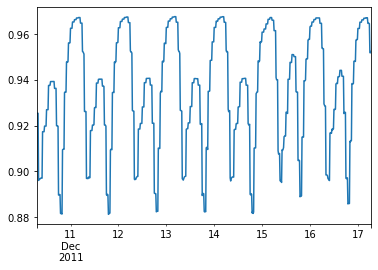

In [43]:
edisgo_curt.results.v_res[bus].iloc[-672:].plot()

In [45]:
edisgo_curt.topology.lines_df.s_nom.head()

name
Branch_Generator_mvgd_177_solar_roof_mounted_1570697_MVCableDist_mvgd_177_14    8.038448
Branch_LVStation_mvgd_177_lvgd_407080_LVStation_mvgd_177_lvgd_407174            8.038448
Branch_LVStation_mvgd_177_lvgd_407080_MVCableDist_mvgd_177_14                   8.038448
Branch_LVStation_mvgd_177_lvgd_407174_LVStation_mvgd_177_lvgd_407187            8.038448
Branch_LVStation_mvgd_177_lvgd_407174_LVStation_mvgd_177_lvgd_407380            8.038448
Name: s_nom, dtype: float64

In [54]:
s = (edisgo_curt.results.pfa_p.apply(np.square) + edisgo_curt.results.pfa_q.apply(np.square)).apply(np.sqrt)

In [58]:
loading = s[edisgo_curt.topology.lines_df.index].divide(edisgo_curt.topology.lines_df.s_nom)

In [59]:
loading.max().max(), loading.min().min()

(1.680098083342877, 0.0)

In [62]:
loading[loading==loading.max().max()].dropna(how='all').dropna(how='all', axis=1)

name,Branch_LVCableDist_mvgd_177_lvgd_42004_127_LVStation_mvgd_177_lvgd_42004
2011-12-16 10:30:00,1.680098


<AxesSubplot:>

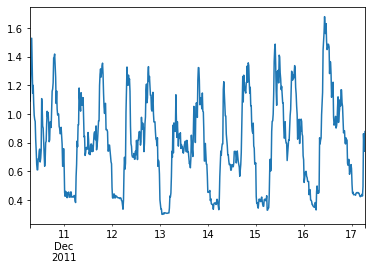

In [63]:
branch = 'Branch_LVCableDist_mvgd_177_lvgd_42004_127_LVStation_mvgd_177_lvgd_42004'
loading[branch].iloc[-672:].plot()

In [64]:
edisgo_curt.topology.lines_df.s_nom[branch]

0.2819085894399105

<AxesSubplot:>

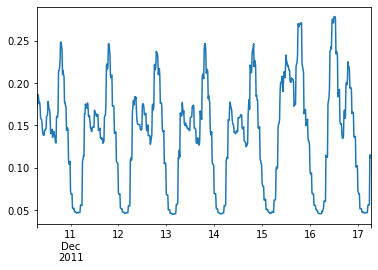

In [65]:
edisgo_curt.results.pfa_q[branch].divide(0.2819085894399105).iloc[-672:].plot()

<AxesSubplot:>

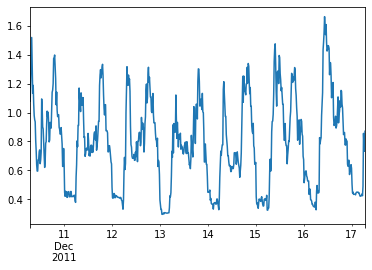

In [66]:
edisgo_curt.results.pfa_p[branch].divide(0.2819085894399105).iloc[-672:].plot()